In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/installs')

In [ ]:
!pip install ase
from ase import Atoms

In [ ]:
!pip install pymatgen

In [ ]:
!pip install --upgrade mendeleev SQLAlchemy==2.0.0

In [ ]:
import mendeleev

In [ ]:
!pip install pycuda
import pycuda

In [ ]:
!pip install graphdot --no-deps
from graphdot import Graph

/usr/local/lib/python3.10/dist-packages/graphdot/graph/__init__.py:23: UserWarning: Cannot import RDKit, `graph.from_rdkit()` will be unavailable.

  warnings.warn(


In [ ]:
# THIS FILE LOADS A TRAINED GPR MODEL AND CALCULATES NUMERICAL APPROXIMATIONS OF THE DERIVATIVES OF ENERGY FUNCTIONALS FOR GIVEN QUANTUM ESPRESSO FILES


# Some imports are not necessary but they have managed to stay around

import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [ ]:
# THIS FILE READS QUANTUM ESPRESSO OUTPUT, TRAINS WITH IT AND CAN ALSO TEST THE RESULTING MODEL

# Some imports are not necessary but they have managed to stay around

import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
#import graphdot
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
#from graphdot.graph.reorder import rcm
from graphdot.kernel.marginalized import MarginalizedGraphKernel # https://graphdot.readthedocs.io/en/latest/apidoc/graphdot.kernel.marginalized.html
from graphdot.kernel.marginalized.starting_probability import Uniform
from graphdot.model.gaussian_process import (
    GaussianProcessRegressor,
    LowRankApproximateGPR,
    GPROutlierDetector
)
from graphdot.kernel.fix import Normalization
from graphdot.kernel.molecular import Tang2019MolecularKernel as MolecularKernel
from ase.io import read

In [ ]:
# Reading gpr model and MD output

dir = '/content/drive/MyDrive/QE_Fe/PBE/High-pressure/2.49_5000K/'
if not os.path.exists(dir + 'Images/'):
  os.mkdir(dir + 'Images/')

gpr = GaussianProcessRegressor(
    # kernel is the covariance function of the gaussian process (GP)
    kernel=Normalization(MolecularKernel()),
    alpha=1e-4, # value added to the diagonal of the kernel matrix during fitting
    optimizer=True, # default optimizer of L-BFGS-B based on scipy.optimize.minimize
    normalize_y=True, # normalize the y values so taht the means and variance is 0 and 1, repsectively. Will be reversed when predicions are returned
    # regularization='+', # alpha (1e-4 in this case) is added to the diagonals of the kernal matrix
)

N_train = 200 # Number of training steps used for the gpr model
gpr.load(dir, 'gpr_DFT_PotEng_3,2_'+str(N_train)+'.pkl') # Change directory

# Read output files into a list of atoms objects
ntsteps = range(1, 6)
ao = []
for f in ntsteps:
    ao.extend(read(dir + 'fe' + str(f) + '.out', index=':', format='espresso-out'))

# This reads Valeria's newer MD outputs across the phase diagram directly from their subdirectories inside HighTempFe
# directory = '/home/adrian/Documents/ML_MD/HighTempFe'
# for subdir, dirs, files in os.walk(directory):
#     for file in files:
#         ao.extend(read(os.path.join(subdir, file), index=':', format='espresso-out'))
#         print(os.path.join(subdir, file))

0.9719921875
[5.74444169e-06 3.82967516e-06] [4.02857387e-05 2.45757672e-01]


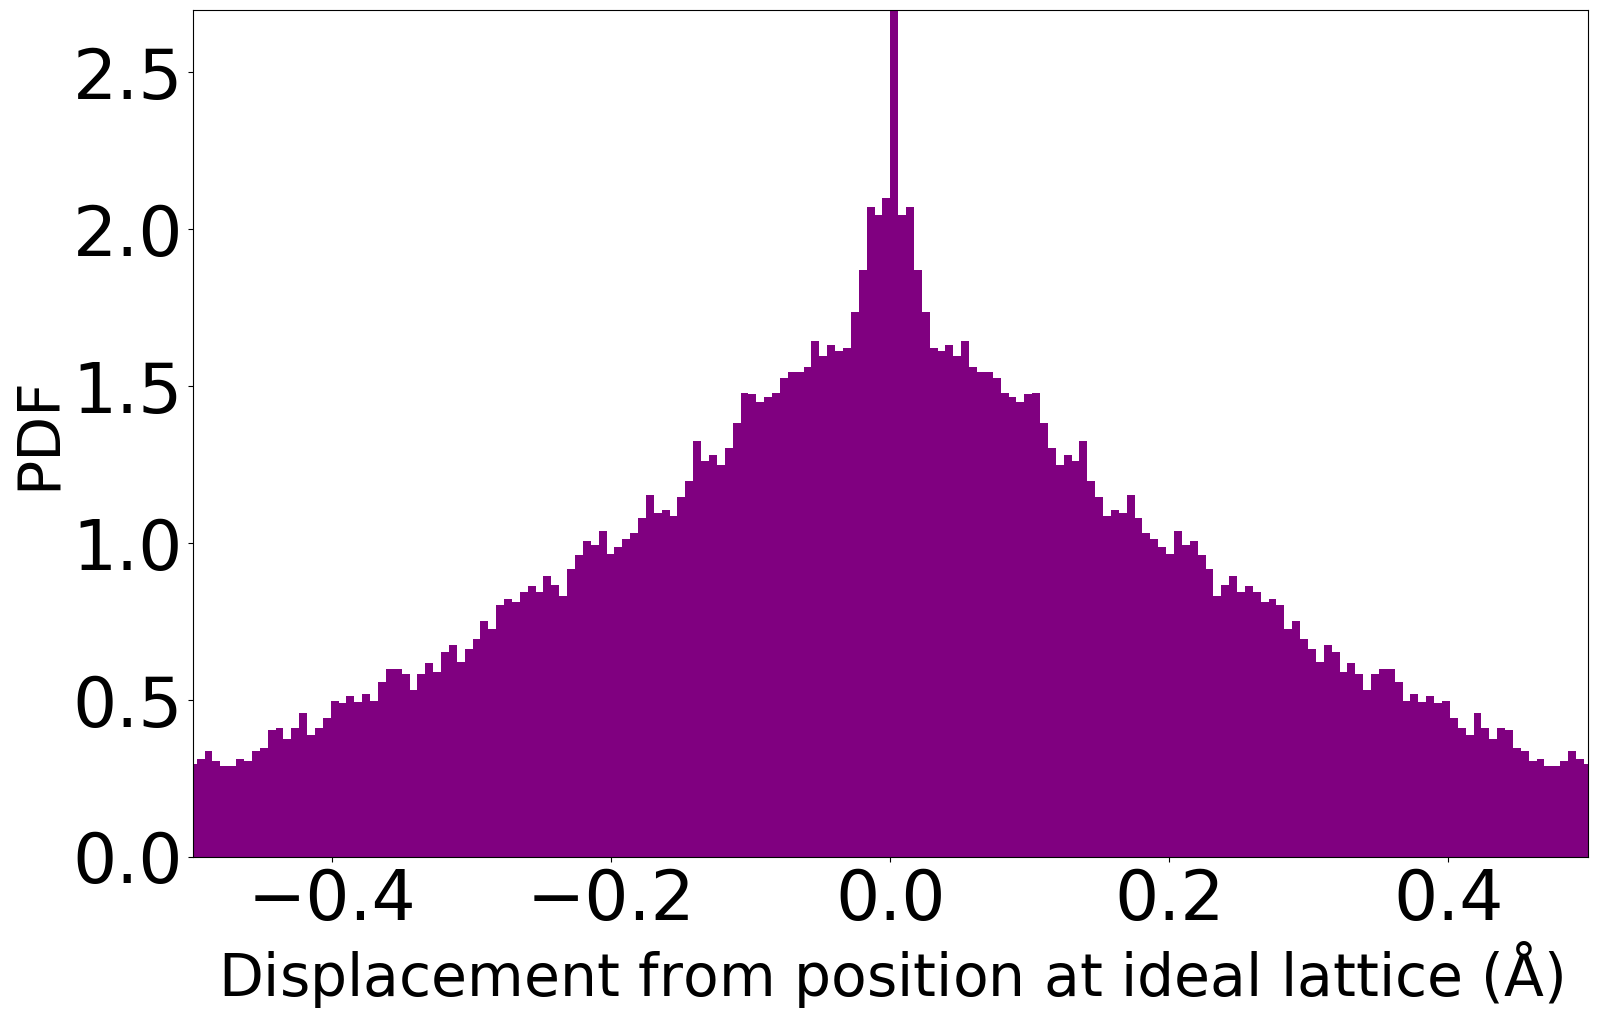

In [ ]:
# Plotting displacement histogram. This is how I have judged reasonable displacements of the atoms in the system, but a more mathematical approach might be useful and convenient

def gaussian(x, x0, mu):
    return np.exp(-(((x - x0) / mu) **2) / 2) / (mu * np.sqrt(2 * np.pi))

ideal = ao[0] # Ideal lattice configuration
ideal_posits = ideal.get_positions()
displacements = [] # List of displacements from ideal lattice in the direction of 2NN
x = 1/np.sqrt(1)
for t in range(200):
    ap = ao[t].get_positions()
    for i in range(128):
      for d in [np.array([x, 0, 0]), np.array([-x, 0, 0]), np.array([0, x, 0]), np.array([0, -x, 0]), np.array([0, 0, x]), np.array([0, 0, -x])]:
            displacements.append(np.dot(ap[i, :] - ideal_posits[i, :], d))

displacements = np.array(displacements)
print(len(displacements[(displacements>=-.6)*(displacements<=.6)]) / len(displacements)) # Proportion of displacements within [-.6, .6]
bin_num = 500 # Number of bins in the histogram
bins =  np.linspace(min(displacements), max(displacements), bin_num+1)
bin_step = (bins[1] - bins[0]) / 2
hist, bins = np.histogram(displacements, bins, density=True)
center_bins = [bins[i] + bin_step for i in range(bin_num)]
popt, pcov = curve_fit(gaussian, center_bins, hist) # Gaussian fit
plt.figure(figsize=(18,11))
plt.hist(displacements, bins=bin_num, density=True, color='purple')
print(np.diag(pcov), popt)
# plt.plot(bins[:60], hist)
# plt.plot(center_bins, gaussian(center_bins, *popt))
#plt.title('Distribution of atom-wise displacements from equilibrium in the direction of their second nearest neighbors')
plt.xlabel(r'Displacement from position at ideal lattice ($\mathrm{\AA}$)', fontsize=42)
plt.ylabel('PDF', fontsize=42)
# Increase the tick size for better readability
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

# Adjust the axis ranges for better readability
plt.xlim([-0.5, 0.5])  # Set x-axis range
plt.ylim([0, 2.7])     # Set y-axis range
plt.savefig(dir + 'Images/2_NN Displacement distribution.png')

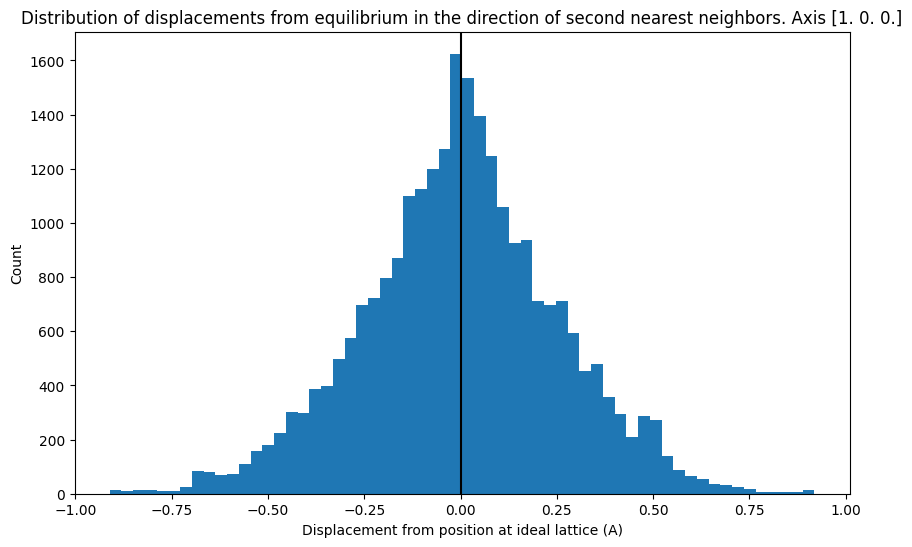

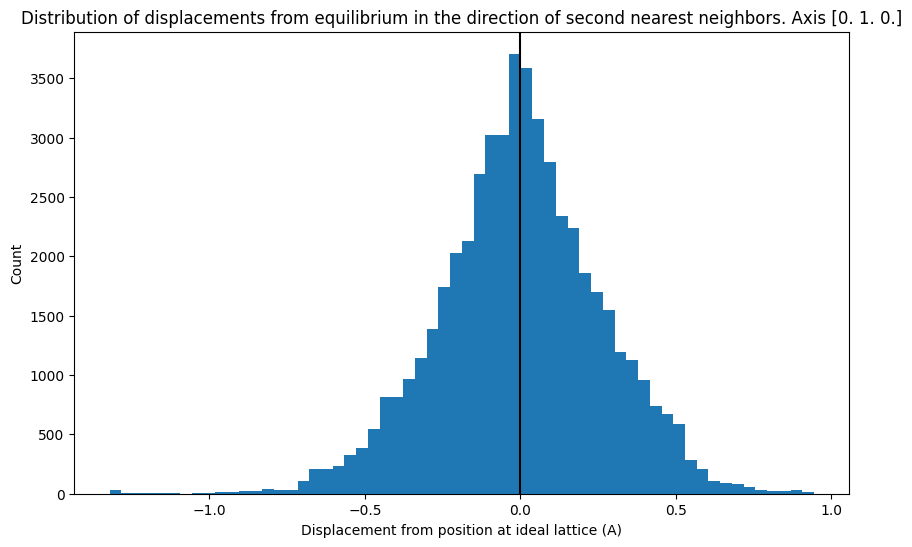

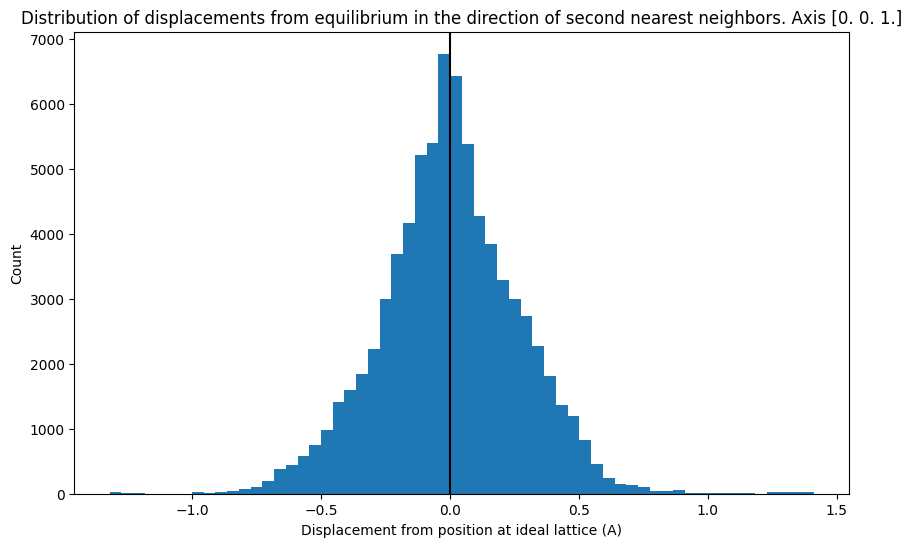

In [ ]:
# Plotting displacement histograms per individual axis

ideal = ao[0]
ideal_posits = ideal.get_positions()
displacements = []
for d in range(3):
    for t in range(200):
        ap = ao[t].get_positions()
        for i in range(128):
            displacements.append(ap[i, d] - ideal_posits[i, d])

    plt.figure(figsize=(10,6))
    plt.hist(displacements, bins=60)
    bottom, top = plt.ylim()
    plt.vlines(0, bottom, top, color='k')
    plt.ylim(bottom, top)
    m = np.zeros(3)
    m[d] = 1
    plt.title('Distribution of displacements from equilibrium in the direction of second nearest neighbors. Axis ' + str(m))
    plt.xlabel('Displacement from position at ideal lattice (A)')
    plt.ylabel('Count')
    plt.savefig(dir + 'Images/2_NN Displacement distribution Axis ' + str(d) + '.png')

In [ ]:
# Creating Graphs from atoms objects list

step_count = 175 # Number of steps between min and max displacement where energy will be evaluated to create the curve
max_displacement = .6
min_displacement = -.6
step = (max_displacement - min_displacement) / step_count
np.random.seed(0)
nstep = np.random.choice(range(len(ao)))
print(nstep)
base = ao[nstep]
ntsteps = range(128)
base_posits = base.get_positions()
var = np.linspace(min_displacement - step, max_displacement + step, num=step_count+3)
graphs = []
for i in ntsteps:
  for d in [np.array([x, 0, 0]), np.array([-x, 0, 0]), np.array([0, x, 0]), np.array([0, -x, 0]), np.array([0, 0, x]), np.array([0, 0, -x])]:
    #for d in range(3):
        print(str(i)+', '+str(d))
        for s in range(step_count+3):
            atoms = base
            positions = base_posits
            positions[i, :] = ideal_posits[i, :] + (var[s] * d)
            #positions[i, :] = ideal_posits[i, :]
            #positions[i, d] += var[s]
            atoms.set_positions(positions)
            # print(atoms.get_positions()[i, :])
            graphs.append(Graph.from_ase(atoms, adjacency=AtomicAdjacency(shape='compactbell3,2')))

172
0, [1. 0. 0.]
0, [-1.  0.  0.]
0, [0. 1. 0.]
0, [ 0. -1.  0.]
0, [0. 0. 1.]
0, [ 0.  0. -1.]
1, [1. 0. 0.]
1, [-1.  0.  0.]
1, [0. 1. 0.]
1, [ 0. -1.  0.]
1, [0. 0. 1.]
1, [ 0.  0. -1.]
2, [1. 0. 0.]
2, [-1.  0.  0.]
2, [0. 1. 0.]
2, [ 0. -1.  0.]
2, [0. 0. 1.]
2, [ 0.  0. -1.]
3, [1. 0. 0.]
3, [-1.  0.  0.]
3, [0. 1. 0.]
3, [ 0. -1.  0.]
3, [0. 0. 1.]
3, [ 0.  0. -1.]
4, [1. 0. 0.]
4, [-1.  0.  0.]
4, [0. 1. 0.]
4, [ 0. -1.  0.]
4, [0. 0. 1.]
4, [ 0.  0. -1.]
5, [1. 0. 0.]
5, [-1.  0.  0.]
5, [0. 1. 0.]
5, [ 0. -1.  0.]
5, [0. 0. 1.]
5, [ 0.  0. -1.]
6, [1. 0. 0.]
6, [-1.  0.  0.]
6, [0. 1. 0.]
6, [ 0. -1.  0.]
6, [0. 0. 1.]
6, [ 0.  0. -1.]
7, [1. 0. 0.]
7, [-1.  0.  0.]
7, [0. 1. 0.]
7, [ 0. -1.  0.]
7, [0. 0. 1.]
7, [ 0.  0. -1.]
8, [1. 0. 0.]
8, [-1.  0.  0.]
8, [0. 1. 0.]
8, [ 0. -1.  0.]
8, [0. 0. 1.]
8, [ 0.  0. -1.]
9, [1. 0. 0.]
9, [-1.  0.  0.]
9, [0. 1. 0.]
9, [ 0. -1.  0.]
9, [0. 0. 1.]
9, [ 0.  0. -1.]
10, [1. 0. 0.]
10, [-1.  0.  0.]
10, [0. 1. 0.]
10, [ 0. -1.  0.]


In [ ]:
# Predicting the energy

prediction = gpr.predict(graphs)
prediction = np.array(prediction)
np.save(dir + '2_NN_Energies_idlt_'+str(nstep)+'_'+str(N_train)+'.npy', prediction) # Change directory

In [ ]:
# Predicting and saving forces. gpr.predict returns a list, so indexing is messy for what would be better suited as a table with two axes

derivative = np.zeros((128, 3, step_count+1))
prediction = np.load(dir + '2_NN_Energies_idlt_'+str(nstep)+'_'+str(N_train)+'.npy') # Change directory
for i in ntsteps:
    for d in range(3): # d represents each dimension of x, y, z
        derivative[i, d, :] = [(prediction[(3 * i + d) * (step_count + 3) + s+1] - prediction[(3 * i + d) * (step_count + 3) + s-1]) / (2 * step) for s in range(1,step_count+2)] # Numerical differentiation through central difference theorem

np.save(dir + '2_NN_Forces_idlt_'+str(nstep)+'_'+str(N_train)+'.npy', derivative) # Change directory

In [ ]:
# Alternative way of iterating through the prediction list to obtain the forces. In case it is more readable

derivative = np.zeros((128, 3, step_count+1))
prediction = np.load(dir + '2_NN_Energies_idlt_'+str(nstep)+'_'+str(N_train)+'.npy')
count=0
for i in ntsteps:
    for d in range(3):
        count+=1
        for s in range(step_count+1):
            derivative[i, d, s] = (prediction[count+1] - prediction[count-1]) / (2 * step)
            count+=1

        count+=1

np.save(dir + '2_NN_Forces_idlt_'+str(nstep)+'_'+str(N_train)+'.npy', derivative)

In [ ]:
# Plotting atom-wise energy and force prediction for each axis

axes = ['x', 'y', 'z']
for i in range(128):
    for d in range(3):
        plt.figure(figsize=(16,9))
        plt.plot(var[1:step_count+2], [prediction[(3 * i + d) * (step_count + 3) + s] for s in range(1,step_count+2)])
        plt.title('Atom #' + str(i) + ' Displacement in ' + axes[d] + ' v System Energy Non-spin-polarized BCC Fe')
        plt.xlabel(r'Displacement from position at ideal lattice ($\mathrm{\AA}$)')
        plt.ylabel(r'Energy of the system (eV)')
        plt.show()
        plt.close()

for i in range(128):
    for d in range(3):
        plt.figure(figsize=(16,9))
        plt.plot(var[1:step_count+2], -derivative[i, d, :])
        plt.title('Atom #' + str(i) + ' Displacement in ' + axes[d] + ' v Force Non-spin-polarized BCC Fe')
        plt.xlabel(r'Displacement from position at ideal lattice ($\mathrm{\AA}$)')
        plt.ylabel(r'Force acting on atom in direction of displacement (eV/$\mathrm{\AA}$)')
        plt.show()
        plt.close()